# Final Project

Course: CUNY DATA620 Web Analytics   
Team Members: Ari & Lucas


For our final project, we examined how the U.S. aviation system can be affected by an airport's importance and local weather. We wanted to use these factors to potentially predict these flight disruptions. This will be done with a ML model using both data combined as our features. To read more into our plans, please check our proposal (https://github.com/lucasweyrich958/DATA620/blob/main/Project%20Proposal.md)

To do this, we prepared data by downloading and cleaning both U.S. flight route and local weather datasets. We then built a knowledge graph using Neo4j AuraDB, modeling airports as :Airport nodes and weather events as :WeatherEvent nodes, linked by flight routes and weather occurrences. This was all done in a different notebook that can be viewed here (https://github.com/lucasweyrich958/DATA620/blob/main/Get_weather.ipynb)

This notebook will consist of the bulk of the project with the data analysis, model predictions, and conclusion.



In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
!pip install neo4j
from neo4j import GraphDatabase
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# --- Neo4j Aura Credentials ---
NEO4J_URI = "neo4j+s://23017e96.databases.neo4j.io"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "seMFXomE_n0aZh76_WkNL07KD8k-o1XLmcwzjEQdKSs" #omitted for security

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))
driver.verify_connectivity()
session = driver.session(database="neo4j")

# Helper function to run queries and return a pandas DataFrame
def run_query(query, params={}):
    with driver.session(database="neo4j", default_access_mode="WRITE") as session:
        result = session.run(query, params)
        return pd.DataFrame([r.data() for r in result])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 4.2 MB/s eta 0:00:00


As mentioned, the data collection is in a different notebook as it took some time to run. __

This data set was then saved in NEO4J so we set up the access point to it above.

## Analysis: Degree Centrality (Most Connections)

Degree centrality is a simple count of how many relationships are connected to a node. For an airport, this tells us how many inbound and outbound routes it has. It's a fundamental measure of how "busy" an airport is.

In [3]:
# Cypher query to get the in-degree, out-degree, and total degree for each airport
degree_query = """
MATCH (a:Airport)
RETURN
  a.iata AS iata,
  COUNT { (a)<--() } AS in_degree,
  COUNT { (a)-->() } AS out_degree,
  COUNT { (a)--() } AS total_degree
ORDER BY total_degree DESC
LIMIT 15
"""

degree_df = run_query(degree_query)
print("Top 15 Airports by Total Degree (Number of Routes):")
display(degree_df)

Top 15 Airports by Total Degree (Number of Routes):


,iata,in_degree,out_degree,total_degree
0,DEN,111,112,223
1,ATL,106,106,212
2,ORD,104,105,209
3,DFW,94,95,189
4,MSP,86,86,172
5,LAS,83,83,166
6,DTW,81,81,162
7,CLT,80,80,160
8,SLC,64,63,127
9,PHL,64,63,127


We can then incorporate airports' local weather into this. This local weather is uses the average weather of areas in all of 2024. For this project, we decided to use the amount of rain and snow as our features because very hot or cold temperature by itself might impact flight disruptions but rain and snow will have a more direct impact given that this affects the runways, vision/sight, etc.

Weather & Degree for Top 25 Busiest Airports (with recorded snow/precip):
   iata  total_degree  avg_max_temp  total_precip_mm  total_snow_mm
0   DEN           223      2.066880            38.34         1761.0
1   ORD           209      1.829000            73.01          539.0
2   MSP           172      0.095469            27.34          178.0
3   DTW           162      0.873613            33.81          420.0
4   PHL           127      2.177810            24.73           64.0
5   SLC           127      1.988400            43.93         1228.0
6   DCA           120      2.118440            72.51          249.0
7   IAD           110      2.118440            72.51          249.0
8   EWR           106      2.011714           127.94          478.0
9   MDW            97      1.829000            73.01          539.0
10  CLE            82      0.309677             1.90           10.0
11  STL            73      2.210661            87.11          153.0
12  PDX            71      1.771355       

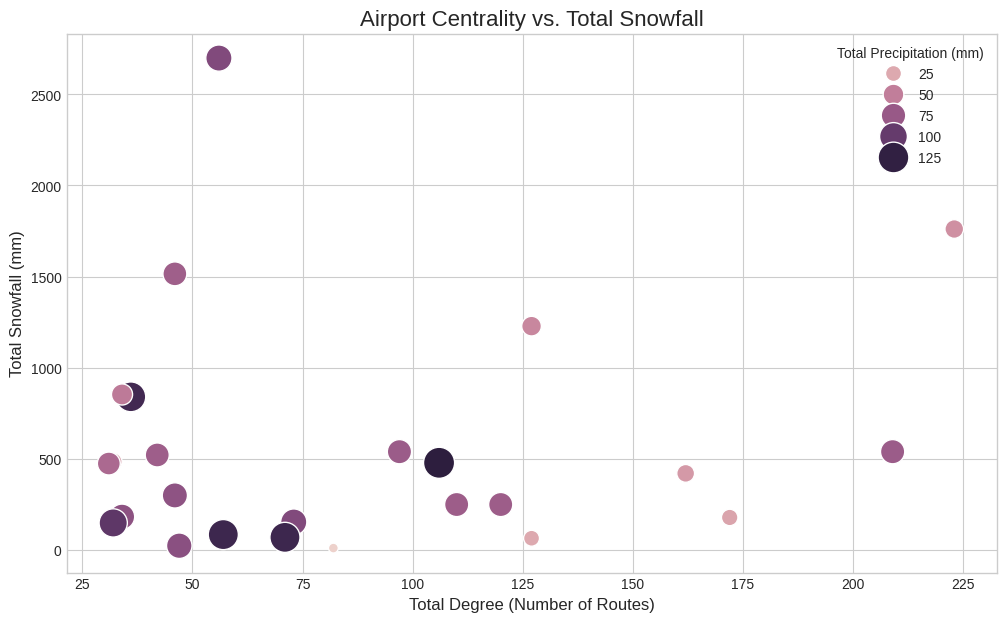

In [4]:
weather_integration_query = """
MATCH (a:Airport)
WHERE a.totalSnowMM > 0 AND a.totalPrecipMM > 0
WITH a, COUNT { (a)--() } AS total_degree
ORDER BY total_degree DESC
LIMIT 25
RETURN
  a.iata AS iata,
  total_degree,
  a.avgMaxTempC AS avg_max_temp,
  a.totalPrecipMM AS total_precip_mm,
  a.totalSnowMM AS total_snow_mm
"""
weather_df = run_query(weather_integration_query)

print("Weather & Degree for Top 25 Busiest Airports (with recorded snow/precip):")
print(weather_df)

# Visualization code
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=weather_df, x='total_degree', y='total_snow_mm', hue='total_precip_mm', size='total_precip_mm', sizes=(50, 500), ax=ax)
ax.set_title('Airport Centrality vs. Total Snowfall', fontsize=16)
ax.set_xlabel('Total Degree (Number of Routes)', fontsize=12)
ax.set_ylabel('Total Snowfall (mm)', fontsize=12)
plt.legend(title='Total Precipitation (mm)')
plt.show()

Major Hubs Are in Snowy Regions: The busiest airports on this list—Denver (DEN), Chicago (ORD), Minneapolis (MSP), and Detroit (DTW)—all have high total_degree and receive significant snowfall. This directly confirms that critical nodes in the U.S. aviation network are located in areas prone to major winter weather events.

Snowfall Outliers Are Apparent: Anchorage (ANC) is a major outlier, with the highest snowfall by a large margin (2699 mm) despite having fewer connections than top-tier hubs. Denver (DEN), Salt Lake City (SLC), and Pittsburgh (PIT) also stand out with exceptionally high snowfall relative to other airports of similar size, making them critical points of interest for weather-related disruption analysis.

Centrality and Weather Aren't Always Linked: While many busy airports get a lot of snow, others like Philadelphia (PHL) have a high degree of connectivity but comparatively little snowfall (64 mm). This provides a useful contrast and shows that not all major hubs face the same level of winter risk.

## Link Predictions
Using the neo4j data, we can now introduce link prediciton where we can predict whether a connection would be likely to exist in the future. This may be interesting to airlines when they want to investigate whether a route would be profitable. This might also helps us form a better understanding of what factors contribute to the formation or disruption of airport links.

In [5]:
# Get all airport nodes with their properties
airports_query = """
MATCH (a:Airport)
WHERE a.totalSnowMM IS NOT NULL
RETURN a.iata AS iata,
       a.latitude AS latitude,
       a.longitude AS longitude,
       a.totalSnowMM AS snow,
       a.totalPrecipMM AS precip,
       COUNT{(a)--()} AS degree
"""
airport_results = session.run(airports_query)
airport_features_df = pd.DataFrame(airport_results.data()).set_index('iata')
print(f"Loaded features for {len(airport_features_df)} airports.")

# Get all existing routes (positive samples)
routes_query = """
MATCH (a1:Airport)-[:FLIES_TO]->(a2:Airport)
RETURN a1.iata AS origin, a2.iata AS destination
"""
routes_results = session.run(routes_query)
positive_samples_df = pd.DataFrame(routes_results.data())
print(f"Loaded {len(positive_samples_df)} existing routes.")

Loaded features for 421 airports.
Loaded 3100 existing routes.


In [6]:
all_airports = set(airport_features_df.index)
existing_routes = set(zip(positive_samples_df['origin'], positive_samples_df['destination']))

negative_samples = []
# Generate a balanced set of negative samples
while len(negative_samples) < len(positive_samples_df):
    origin, dest = random.sample(list(all_airports), 2)
    # Ensure the randomly generated route doesn't already exist
    if (origin, dest) not in existing_routes and (dest, origin) not in existing_routes:
        negative_samples.append({'origin': origin, 'destination': dest})

negative_samples_df = pd.DataFrame(negative_samples)

### Label data frame and engineer additional features

In [7]:
# Assign the target variable (1 for existing routes, 0 for non-existent)
positive_samples_df['target'] = 1
negative_samples_df['target'] = 0

# Combine positive and negative samples into one DataFrame
ml_df = pd.concat([positive_samples_df, negative_samples_df]).reset_index(drop=True)

# Join features for the origin airport
ml_df = ml_df.merge(airport_features_df, left_on='origin', right_index=True)
ml_df.rename(columns={'latitude': 'origin_latitude', 'longitude': 'origin_longitude', 'snow': 'origin_snow', 'precip': 'origin_precip', 'degree': 'origin_degree'}, inplace=True)

# Join features for the destination airport
ml_df = ml_df.merge(airport_features_df, left_on='destination', right_index=True)
ml_df.rename(columns={'latitude': 'dest_latitude', 'longitude': 'dest_longitude', 'snow': 'dest_snow', 'precip': 'dest_precip', 'degree': 'dest_degree'}, inplace=True)

# Create the preferential attachment feature (degree of origin * degree of destination)
ml_df['pref_attachment'] = ml_df['origin_degree'] * ml_df['dest_degree']


# Control the columns for the displays
cols_to_exclude = ['origin_latitude', 'origin_longitude', 'dest_latitude', 'dest_longitude']
cols_to_show = [col for col in ml_df.columns if col not in cols_to_exclude]

# Display head of target=1 rows
print("Existing Routes:")
display(ml_df[ml_df['target'] == 1].sort_values(by='pref_attachment', ascending=False)[cols_to_show].head(10))

# Display head of target=0 rows
print("\nNon-Existent Routes:")
display(ml_df[ml_df['target'] == 0].sort_values(by='pref_attachment', ascending=False)[cols_to_show].head(10))

#display(ml_df.head())

Existing Routes:


,origin,destination,target,origin_snow,origin_precip,origin_degree,dest_snow,dest_precip,dest_degree,pref_attachment
1604,DEN,ATL,1,1761.0,38.34,223,0.0,122.33,212,47276
1217,ATL,DEN,1,0.0,122.33,212,1761.0,38.34,223,47276
1931,ORD,DEN,1,539.0,73.01,209,1761.0,38.34,223,46607
1623,DEN,ORD,1,1761.0,38.34,223,539.0,73.01,209,46607
1224,ATL,ORD,1,0.0,122.33,212,539.0,73.01,209,44308
1921,ORD,ATL,1,539.0,73.01,209,0.0,122.33,212,44308
1600,DEN,DFW,1,1761.0,38.34,223,0.0,80.17,189,42147
1034,DFW,DEN,1,0.0,80.17,189,1761.0,38.34,223,42147
1198,ATL,DFW,1,0.0,122.33,212,0.0,80.17,189,40068
1015,DFW,ATL,1,0.0,80.17,189,0.0,122.33,212,40068



Non-Existent Routes:


,origin,destination,target,origin_snow,origin_precip,origin_degree,dest_snow,dest_precip,dest_degree,pref_attachment
6038,SLC,IAD,0,1228.0,43.93,127,249.0,72.51,110,13970
5495,ALB,DEN,0,840.0,116.63,36,1761.0,38.34,223,8028
3950,IAD,PIE,0,249.0,72.51,110,0.0,95.04,46,5060
4629,FLL,ANC,0,0.0,162.16,82,2699.0,87.54,56,4592
5962,LIT,MSP,0,61.0,101.57,25,178.0,27.34,172,4300
3990,SLC,ROC,0,1228.0,43.93,127,0.0,25.13,28,3556
3351,PDX,SAT,0,69.0,119.21,71,0.0,63.94,48,3408
5389,PSC,ATL,0,0.0,14.26,16,0.0,122.33,212,3392
4618,MLI,CLT,0,414.0,72.62,20,0.0,152.88,160,3200
4693,SFO,OMA,0,0.0,113.32,94,474.0,63.99,31,2914


In order to see the difference/why certain routes exist and others don't based on our features. We printed out the top highest pref_attachment rows of both existing and non-existing routes above. We can see that pref_attachment especially are wildly different. This is expected as it is based on the degrees of the origin and dest airports which would be fairly good indictors for predictions.

Surprisely, the numbers for snow and rain vary a lot more than we thought. In the top 5 existing routes, we can see 0s and really high amounts of snow giving the illusion that if weather does play a big role in choosing major hubs, it's either places that don't deal with crazy weather or ones that are very used to it. Rain seems to not have too much of a difference in the existing routes.

### Train Models

Our next step is to train our model. We chose a Random Forest model because it performs well with purely numeric data and can capture complex, non-linear relationships between features. It is also robust to outliers and doesn't require feature scaling or normalization, which made it a good fit for our dataset.

First, we created a basic model with  just origin and dest degrees as our features. This is our controlled model. The goal for these is to predict target, if it is a existing or non-existing routes/can we predict routes based on these features (assume routes as often chosen if they are profitable and relible).

In [8]:
# Define the features to be used for training
features = [
    'origin_degree', 'dest_degree','pref_attachment'
]
X = ml_df[features]
y = ml_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Random Forest model
#print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("\n Basic Model Classification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {classification_report(y_test, model.predict(X_test), output_dict=True)['accuracy'] * 100:.2f}%")



 Basic Model Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       930
           1       0.90      0.88      0.89       930

    accuracy                           0.89      1860
   macro avg       0.89      0.89      0.89      1860
weighted avg       0.89      0.89      0.89      1860

Accuracy: 89.03%


We can see this did a pretty good job on its own, however, there is a lot of improvements we can do as its not quite in the 90s yet.

Let's implement our weather features that our project is based on. We will also print out some stats on feature importances as well.

In [9]:
# Define the features to be used for training
features = [
    'origin_degree', 'origin_snow', 'origin_precip',
    'dest_degree', 'dest_snow', 'dest_precip',
    'pref_attachment'
]
X = ml_df[features]
y = ml_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Random Forest model
print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

Training Random Forest Classifier...


RandomForestClassifier(n_jobs=-1, random_state=42)

### Evaluate Model and Feature Importance


 Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       930
           1       0.91      0.91      0.91       930

    accuracy                           0.91      1860
   macro avg       0.91      0.91      0.91      1860
weighted avg       0.91      0.91      0.91      1860

Accuracy: 91.02%

✨ Feature Importances:


,feature,importance
6,pref_attachment,0.433548
0,origin_degree,0.183535
3,dest_degree,0.176192
2,origin_precip,0.071237
5,dest_precip,0.067213
1,origin_snow,0.036250
4,dest_snow,0.032026


/tmp/ipython-input-10-2166866294.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


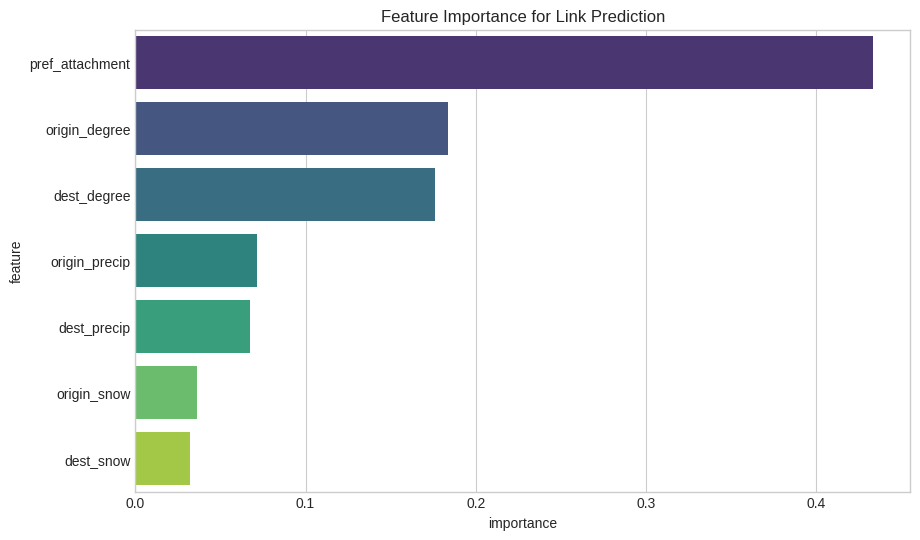

In [10]:
# Evaluate the model's performance on the test set
print("\n Classification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {classification_report(y_test, model.predict(X_test), output_dict=True)['accuracy'] * 100:.2f}%")

# Analyze Feature Importance

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✨ Feature Importances:")
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Link Prediction')
plt.show()

The accuracy rate with the weather features is higher than the basic model and reached the 90%s! This means weather features do have an affect on predicting these routes. We can see in the breakdown of feature importance that the other three pref_attachment, origin_degree, and dest_degree do still rank higher on the list than the weather features but this is expected. The weather features are merely there to assist and boost which it does!

# Adding more to the model

When looking at the top airports early (Denver (DEN), Chicago (ORD), Minneapolis (MSP), and Detroit (DTW)), we can see a bit of a pattern or commonity to all. They are all in the North of the United States or similar latitudes! This got us thinking of a couple features that might also be good to add for the predictions: latitude and longitude. Below is the data analysis of these two.

Geographic Coordinates for Top 25 Busiest Airports:
   iata  total_degree   latitude   longitude
0   DEN           223  39.861698 -104.672997
1   ORD           209  41.978600  -87.904800
2   MSP           172  44.882000  -93.221802
3   DTW           162  42.212399  -83.353401
4   PHL           127  39.871899  -75.241096
5   SLC           127  40.788399 -111.977997
6   DCA           120  38.852100  -77.037697
7   IAD           110  38.944500  -77.455803
8   EWR           106  40.692501  -74.168701
9   MDW            97  41.785999  -87.752403
10  CLE            82  41.411701  -81.849800
11  STL            73  38.748697  -90.370003
12  PDX            71  45.588699 -122.598000
13  BNA            57  36.124500  -86.678200
14  ANC            56  61.174400 -149.996002
15  MEM            47  35.042400  -89.976700
16  IND            46  39.717300  -86.294403
17  PIT            46  40.491501  -80.232903
18  MKE            42  42.947201  -87.896599
19  ALB            36  42.748299  -73.801697
20 

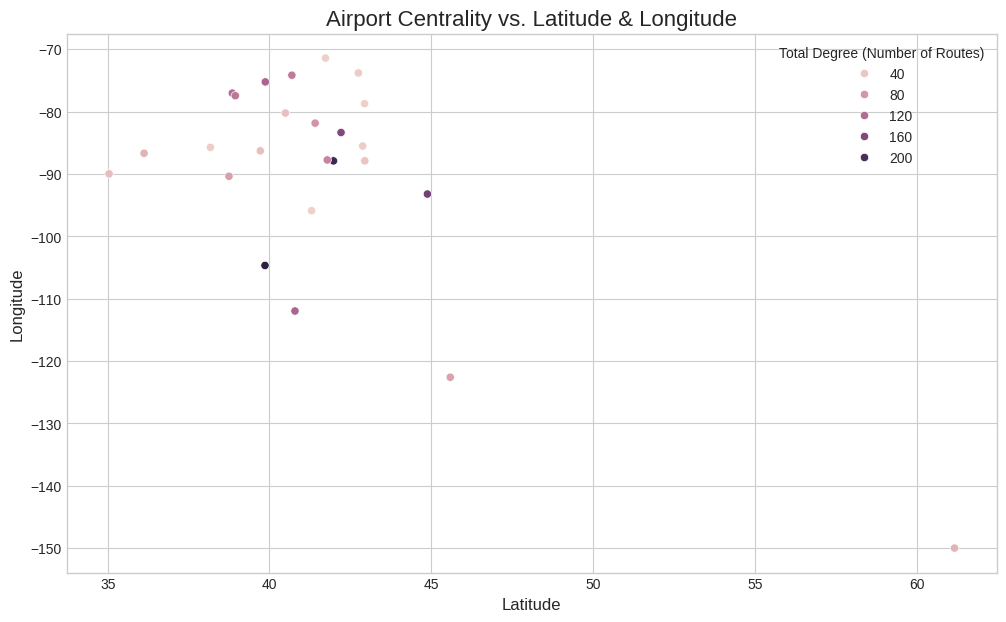

In [11]:
geo_coordinates_integration_query = """
MATCH (a:Airport)
WHERE a.totalSnowMM > 0 AND a.totalPrecipMM > 0
WITH a, COUNT { (a)--() } AS total_degree
ORDER BY total_degree DESC
LIMIT 25
RETURN
  a.iata AS iata,
  total_degree,
  a.latitude AS latitude,
  a.longitude AS longitude
"""
geo_coordinates_integration_query = run_query(geo_coordinates_integration_query)

print("Geographic Coordinates for Top 25 Busiest Airports:")
print(geo_coordinates_integration_query)

# Visualization code
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=geo_coordinates_integration_query, x='latitude', y='longitude', hue='total_degree', sizes=(50, 500), ax=ax)
ax.set_title('Airport Centrality vs. Latitude & Longitude', fontsize=16)
ax.set_xlabel('Latitude', fontsize=12)
ax.set_ylabel('Longitude', fontsize=12)
plt.legend(title='Total Degree (Number of Routes)')
plt.show()

We can see on the graph that while there is no fully clear pattern, we can see that the biggest on dots (highest degrees) sit in a specific area of the graph. The sweet spot for latitudes looks to be between 40 and 45 while all the highest of high degreed airports are around -80 to -105 for longitude as well. With this clear area of density, this should be good features to add to our model.

Training Random Forest Classifier...

 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       930
           1       0.92      0.95      0.93       930

    accuracy                           0.93      1860
   macro avg       0.93      0.93      0.93      1860
weighted avg       0.93      0.93      0.93      1860

Accuracy: 93.17%

✨ Feature Importances:


,feature,importance
10,pref_attachment,0.438293
0,origin_degree,0.132595
5,dest_degree,0.130440
8,dest_latitude,0.059632
3,origin_latitude,0.056005
9,dest_longitude,0.053609
4,origin_longitude,0.051925
7,dest_precip,0.024570
2,origin_precip,0.024564
1,origin_snow,0.015445


/tmp/ipython-input-12-3776730690.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


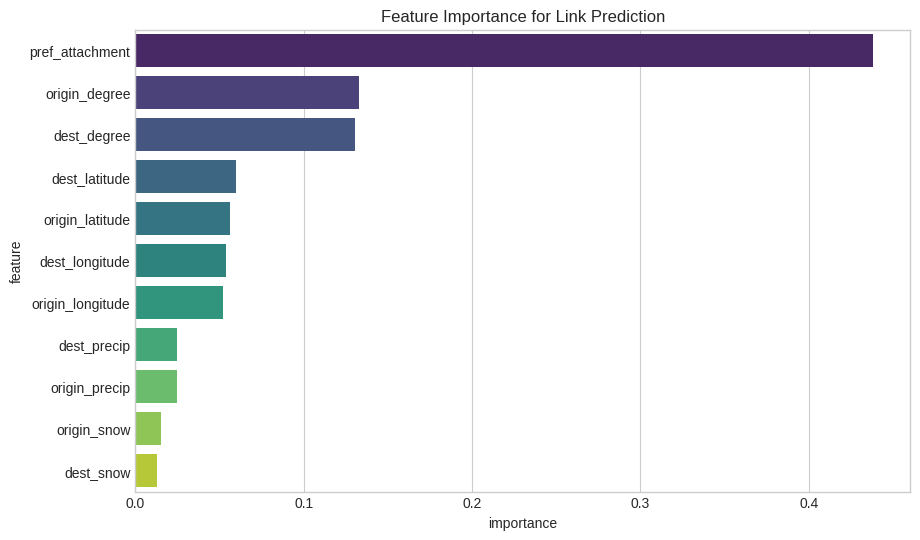

In [12]:
# Define the features to be used for training
features = [
    'origin_degree', 'origin_snow', 'origin_precip', 'origin_latitude', 'origin_longitude',
    'dest_degree', 'dest_snow', 'dest_precip', 'dest_latitude', 'dest_longitude',
    'pref_attachment'
]
X = ml_df[features]
y = ml_df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Random Forest model
print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate the model's performance on the test set
print("\n Classification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {classification_report(y_test, model.predict(X_test), output_dict=True)['accuracy'] * 100:.2f}%")

# Analyze Feature Importance

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✨ Feature Importances:")
display(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance for Link Prediction')
plt.show()

This did much better than the previous two and will different seed testing, it did past the 95% mark a few times. Just like before, these new non-weather features are also higher on the feature importance than the weather features.

# Conclusion
### Network Structure

The model's predictions are overwhelmingly driven by the network's existing structure.

pref_attachment is the most dominant feature by a wide margin. This means that the combined connectivity of two airports (the product of their individual number of routes) is the single best predictor. In simple terms, hubs are extremely likely to connect to other hubs.

origin_degree and dest_degree are the next most important features, reinforcing the same point. An airport's individual importance is a primary factor.

Together, these top three network features account for over 78% of the model's predictive power.

### Weather Plays a Supporting Role

While weather is a factor, it is significantly less influential than the network structure.

Precipitation (origin_precip, dest_precip) has a modest impact on the prediction.

Snowfall (origin_snow, dest_snow) is the least important factor the model considered.

This is probably due to even if there is "bad weather" or more rain and snow than other places, these airports are usual to it in this area and know how to still operate smoothly through it.

### Additional features that play a bigger role

Adding the latitude and longitude of each airport further improved the model's performance, suggesting that geography provides useful context beyond airports' weather. These features may help the model capture spatial patterns, such as regional connectivity trends or the tendency for nearby airports to be more likely candidates for new routes.


In short, to get back to our inital query, the model learned that to predict a new flight route, knowing how connected the airports already are is far more important than knowing what the weather is like at each location.